# SPAMASSASSINs

In [341]:
#!/usr/bin/env python
# coding: utf-8
# andrevrpires

Essa é minha primeira experiência "solo" com machine learning. Depois de fazer o curso do Andrew NG, na plataforma Coursera, estou começando a tentar algumas coisas sozinho. Minha idéia é ir apresentando algumas soluções aqui, como um pequeno portfólio. 

(O "solo", entre aspas, é porque o problema aqui tratado é proposto como desafio no próprio curso do Andrew, para ser resolvido a partir da solução de um problema parecido.)

Então, aqui vamos. Usando os dados em https://spamassassin.apache.org/old/publiccorpus/, treinamos a máquina para  identificar automaticamente quais emails são "spam". É um problema de classificação binária, e comparamos as precisões obtidas a partir de Regressão Logística e a partir de SVM. Mas a parte da classificação é simples se tivermmos os dados do jeito que precisamos... em uma linha o Python treina o modelo, em mais uma aplica nos dados de teste. A parte mais interessante do problema é como transformar cada texto de email em um objeto mais simples que possa ser matematicamente classificado como "spam" ou "não-spam". 

A primeira pergunta então é: que palavras do texto de email podem ser usadas para diferenciá-los uns dos outros? Para responder a essa pergunta, fizemos uma contagem de palavras mais frequentes entre os dois grupos e os comparamos. Abaixo temos o script que extrai as palavras dos emails, para que a contagem possa ser feita, mas que já faz algum tratamento dessas palavras. No processo para criar essa parte do script, fizemos vários testes, fazendo o treinamento da máquina até o fim, observando a precisão, e fazendo novas alterações até obter a melhor performance possível.

## O tokenizer

In [342]:
#Bibliotecas
import os, email, nltk
from bs4 import BeautifulSoup

def tokenize_email(fullpath):
    
    # esta função recebe um caminho de arquivo de email e extrai um vetor de palavras
    # ao extrair o vetor de palavras, estas recebem alguns tratamentos, descritos a seguir
    # a função será usada dentro de outra, descrita a seguir, que itera sobre os arquivos de uma dada pasta
    
    try:
        # abre o arquivo de email e lê os dados do arquivo
        open_email = open(fullpath, "r")
        read_email = open_email.read()
        # extrai a mensagem do email, e depois o corpo do email
        data_email = email.message_from_string(read_email) 
        message_email = data_email.get_payload()
        # remove o a marcação html dos emails
        # (observando a ocorrências de marcação html em cada tipo a ser classificado,
        #  vimos que estes têm alta frequência nos emails de spam. Porém, ao testar, percebemos
        #  que removê-los da lista melhora a performance dos classificadores)
        soup = BeautifulSoup(message_email, "html.parser")
        message_email = soup.text
        # cria um reconhecedor de padrões e os extrai, criando um vetor com os padrões reconhecidos
        tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
        tokens_email = tokenizer.tokenize(message_email)
        # coloca todas as letras em minúsculas
        tolower_email = [word.lower() for word in tokens_email]
        # remove todos os números encontrados
        # (observando a contagem de ocorrências de números em cada tipo a ser classificado,
        #  foi identificado que estes têm alta frequência em ambos os casos. Testando, percebemos
        #  que removê-los da lista melhora a performance dos classificadores)
        for token in tolower_email:
            if token.isnumeric():
                tolower_email.remove(token)
        # remove as 'stopwords'
        stopwords = nltk.corpus.stopwords.words('english')
        stopped_email = [word for word in tolower_email if word not in stopwords]
        # retorna o email tokenizado
        return(stopped_email)
        
    except:
        # caso ocorra algum erro, retorna FALSO, pulando o email com problema
        return(0)

def tokenize_directory(directory):
    
    # essa função aplica a função tokenize_email a todos os arquivos de um diretório dado
    # como resultado, retorna uma lista com cada um dos emails tokenizados

    # inicializando a lista de emails tokenizados
    lista = []

    #iterando sobre os arquivos do diretório
    for file in os.listdir(directory):
    
        # extraindo o nome do arquivo e passando como parâmetro para a função tokenize_email
        filename = os.fsdecode(file)
        fullpath = os.path.join(directory, filename)
        email_tokens = tokenize_email(fullpath)
        
        # checa se a tokenização obteve sucesso, e no caso positivo adiciona o email tokenizado à lista
        if email_tokens:
            lista.append(email_tokens)
    
    #retorna a lista de emails tokenizados
    return(lista)

def plot_freqdist_freq(fd,
                       max_num=None,
                       cumulative=False,
                       title='Frequency plot',
                       linewidth=2):
    
    """
    
    O nltk versão 3.2.1 FreqDist.plot() plota a contagem, mas não tem um argumento
    para normalizar e obter a frequência. Esta função contorna esse problema
    
    INPUT:
        - o objeto FreqDist
        - max_num: se especificado, plota até esse número de elementos
          (eles já são ordenados em ordem decrescente pelo FreqDist)
        - cumulative: booleano (default = False)
        - title: título para o gráfico
        - linewidth: a espessura de linha a ser usada(default = 2)
        
    OUTPUT:
        - plota a frequência e retorna None
    
    """

    common = fd.most_common(max_num)
    tmp = nltk.FreqDist()
    norm = fd.N()
    for element in common:
        tmp[element[0]] = float(fd[element[0]]) / norm

    if max_num:
        tmp.plot(max_num, cumulative=cumulative,
                 title=title, linewidth=linewidth)
    else:
        tmp.plot(cumulative=cumulative, 
                 title=title, 
                 linewidth=linewidth)

    return

Desenvolvidas as funções que darão o primeiro tratamento aos dados, vamos aplicá-las...

In [343]:
directory = ("/Users/andrevrpires/Downloads/ML/DadosSpam/spam/")
spam_lista = tokenize_directory(directory)

directory = ("/Users/andrevrpires/Downloads/ML/DadosSpam/nospameasy/")
nospam_lista = tokenize_directory(directory)

directory = ("/Users/andrevrpires/Downloads/ML/DadosSpam/hardham/")
hardnospam_lista = tokenize_directory(directory)

nospam_lista += hardnospam_lista

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp



" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


... e agora podemos fazer alguns gráficos:

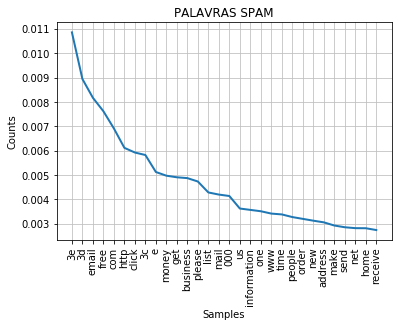

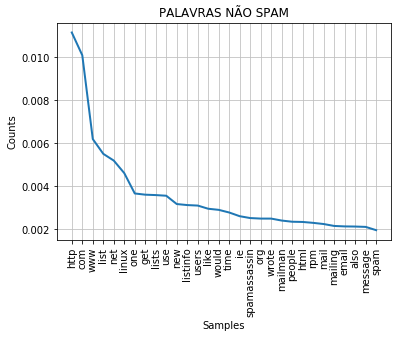

In [344]:
# transformando todos os vetores de emails spam num vetor só, para contagem
spam = [item for sublist in spam_lista for item in sublist]
fdspam = nltk.FreqDist(spam)
plot_freqdist_freq(fdspam, max_num = 30, title = 'PALAVRAS SPAM')

# transformando todos os vetores de emails não spam num vetor só, para contagem
nospam = [item for sublist in nospam_lista for item in sublist]
fdnospam = nltk.FreqDist(nospam)
plot_freqdist_freq(fdnospam, max_num = 30, title = 'PALAVRAS NÃO SPAM')


Podemos ver que a boa parte das palavras mais frequentes entre os dois grupos são diferentes. Vamos checar a porcentagem de diferença.

In [345]:
size = 30

spamtudo = [item for sublist in spam_lista for item in sublist]
fdspam = nltk.FreqDist(spamtudo)
palavras_spam  = [i[0] for i in fdspam.most_common(size)]

NOspamtudo = [item for sublist in nospam_lista for item in sublist]
fdNOspam = nltk.FreqDist(NOspamtudo)
palavras_NOspam  = [i[0] for i in fdNOspam.most_common(size)]

len([i for i in palavras_spam if i not in palavras_NOspam])/size

0.6

Para as primeiras 30 palavras, 18 são exclusivas de spam. Além disso, observe que algumas das palavras iguais aparecem em proporções diferentes em cada grupo. A palavra "email", por exemplo, aparece em 0.8% das mensagens spam, e 0.2% das mensagens não spam.

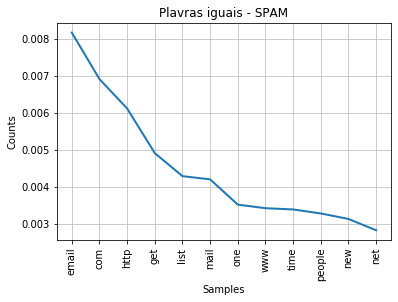

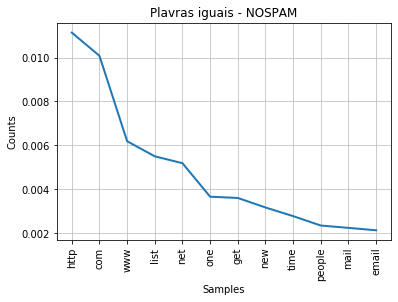

In [346]:
commonspam = [i for i in fdspam.most_common(30) if i[0] in [i[0] for i in fdnospam.most_common(30)]]
commonnospam = [i for i in fdnospam.most_common(30) if i[0] in [i[0] for i in fdspam.most_common(30)]]
tmp = nltk.FreqDist()
norm = fdspam.N()
for element in commonspam:
    tmp[element[0]] = float(fdspam[element[0]]) / norm
tmp.plot(title = 'Plavras iguais - SPAM')

tmp = nltk.FreqDist()
norm = fdnospam.N()
for element in commonnospam:
    tmp[element[0]] = float(fdnospam[element[0]]) / norm
tmp.plot(title = 'Plavras iguais - NOSPAM')

Quando aumentamos o número de palavras contadas, encontramos mais relações de proporção como estas. Descobrimos que, no fim das contas, não existem palavras "exclusivas" para spam. O que acontece é que cada palavra é como a palavra "email": a presença ou não contribui com um percentual de chance de classificar ou não como spam. Agora, é trabalho do algoritmo de classificação definir qual o "peso" de cada palavra, certo? Nos resta então dizer se a palavra está ou não na mensagem. Começamos fazendo a lista das palavras que vamos checar:

In [347]:
def listar_palavras_spam(spam_lista, size):
    
    spamtudo = [item for sublist in spam_lista for item in sublist]
    fdspam = nltk.FreqDist(spamtudo)
    palavras_spam  = [i[0] for i in fdspam.most_common(size)]
    return(palavras_spam)

## O vectorizer

In [348]:
import numpy

def email_vectorize(lista_emails, palavras_spam):
    
    # esta função toma como base um vetor de "palavras spam"
    # a partir deste, retorna um vetor de zeros e uns, onde um significa que a "palavra spam" está no email
    # cada um dos emails é uma linha na matriz
    # cada uma das "palavras spam" é uma coluna na matriz
    
    sz1 = len(lista_emails)
    sz2 = len(palavras_spam)
    data = numpy.zeros((sz1, sz2), int)

    for i, email in enumerate(lista_emails):
        vector = numpy.zeros(sz2) 
        for j, item in enumerate(palavras_spam):
            if item in email:
                data[i][j] = 1
    
    return(data)

Agora aplicamos nossas funções nos dados tratados e temos algo que o algoritmo de classificação "entenda"!

In [349]:
palavras_spam = listar_palavras_spam(spam_lista, 1000)

data_spam = email_vectorize(spam_lista, palavras_spam)
data_nospam = email_vectorize(nospam_lista, palavras_spam)

X = numpy.concatenate((data_spam, data_nospam), axis = 0)
y = numpy.concatenate((numpy.zeros(data_spam.shape[0], int),
                       numpy.ones(data_nospam.shape[0], int)), axis = 0)

In [350]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm

X, y = shuffle(X, y, random_state = 123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [351]:
model1 = LogisticRegression(solver = 'lbfgs').fit(X_train, y_train)
model1.score(X_test, y_test)

0.993427704752275

In [352]:
model2 = svm.LinearSVC(max_iter = 4000).fit(X_train, y_train)
model2.score(X_test, y_test)

0.9908998988877654

In [353]:
model3 = svm.SVC(gamma='scale').fit(X_train, y_train)
model3.score(X_test, y_test)

0.9919110212335692